<div style="text-align: center;">

# **Algoritmia Cuantica** 
# Periodicidad con varios qbits
  
<font size="2">

##### Daniel Amauri Vázquez Gutiérrez
</font>

Ahora replicaremos lo aprendido en la practica $6$ en esta , pero ahora expandiendolo a mas de 2 qbits como lo vimos. 




In [2]:
#Bloque de importacion
import numpy as np 
import math
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import Aer #Aer es un modulo de Qiskit que proporciona simuladores cuanticos para ejecutarlos de manera local.  
from qiskit.quantum_info import Statevector,DensityMatrix
from qiskit.visualization import plot_histogram,plot_bloch_multivector
from qiskit.circuit import Gate

import qiskit 
print(qiskit.version.get_version_info()) 

1.2.0


Para esto requeriremos especificar el numero *qbits de estimacion* y  *qbits de apoyo* emplearemos , asi como el *periodo* que le infundiremos  a nuestros qbits como cadena , para que de esta forma podamos comparar el periodo estimado alfinal del programa con el inducido al inicio de este.  

Entonces, apartir de las limitaciones que tiene el algoritmo *Quantum Period Finding* , vemos que  forzosamente el periodo  $r$ tiene que ser de la forma:  

$$r=2^j  , j \in \mathbb{N}$$

Ademas , sabemos la siguiente relacion que debe de tener  el *periodo*, el numero de *qbits de estimacion* y el numero de *qbits de apoyo*:


$$r\leq 2^{s} < 2^{2s}\leq 2^{t}=\leq 2^{2s+1}$$  

In [3]:
s=int(input("Ingresa un numero natural mayor igual a 1 , que sera nuestro numero total de qbits de apoyo : ")) 
t=2*s
print("Número de Qbits de estimacion:", t)
print("Número de Qbits de apoyo:", s)

Número de Qbits de estimacion: 6
Número de Qbits de apoyo: 3


Intentaremos primero inducir solo una funcion de dos valores.  

$$
f(x) = 
\begin{cases} 
    1, & \text{si } x  \text{ comienza el periodo } \\ 
    0, & \text{cualquier otro valor } 
\end{cases}
$$ 



Notamos que la funcion que estoy definiendo conuerda muy bien con  la funcion *modulo 2*, por lo que volveremos a implementar el *Quantum period finding* para un periodo igual a 2 . 

In [4]:
# Definir la compuerta personalizada que realiza la Transformada Cuantica 
class QFT(Gate):
    def __init__(self, s):
        # n es el numero que será representado en binario, s es el número de qubits
        super().__init__('QFT_CUSTOM', s,[])  # La etiqueta de la compuerta y el número de qubits
        self.s = s
        
       

    def _define(self):
        qc = QuantumCircuit(self.s)

        # Aplicar la Transformada Cuantica de Fourier 
        for j in range(self.s):
            qc.h(self.s - (j + 1))
            if self.s - (j + 1) > 0:
                for k in range(self.s - (j + 1)):
                    l = self.s - (j + 1) - 1 - k
                    qc.cp(2 * np.pi / (2 ** (self.s - j - l)), l, self.s - (j + 1))

        # Aplicar los swaps necesarios
        if self.s % 2 == 1:
            for l in range((self.s - 1) // 2):
                qc.swap(l, self.s - 1 - l)
        else:
            for l in range(self.s // 2):
                qc.swap(l, self.s - 1 - l)

        self.definition = qc  

In [5]:
#Transformada Cuantica de Fourier Inversa  

class IQFT(Gate):
    def __init__(self, s):
        # n es el numero que será representado en binario, s es el número de qubits
        super().__init__('IQFT_CUSTOM', s, [])  # La etiqueta de la compuerta y el número de qubits
        self.s = s
        

    def _define(self):
         qc = QuantumCircuit(self.s)
 
         #Primero volvemos a Switchear 
         if self.s % 2 == 1:
               for l in range((self.s - 1) // 2):
                  qc.swap(l, self.s - 1 - l)
         else:
               for l in range(self.s // 2):
                  qc.swap(l, self.s - 1 - l)


            #Volvemos a añadir las compuertas pero ahora en un sentido invertido 

         for j in range(self.s):  
               qc.h(j)

               if j<(self.s-1):
                  for k in range(j+1):
                     qc.cp(2*np.pi/(-2**(k+2)),j+1,j-k)   

         
            #Agragamos este SWAP que no deberia ser nesesario , sin embargo , lo ponemos dado que esto nos permite ver los estados de los Qbits en un orden
            #usal en el que vemos los numeros binarios y asi poderlo comparar con el arreglo original que producimos al inicializar el circuito. 

         
         self.definition = qc  

In [6]:
# SWAP  cumtomizado  
class SWAP(Gate):
    def __init__(self, s):
        # n es el numero que será representado en binario, s es el número de qubits
        super().__init__('SWAP_CUSTOM', s, [])  # La etiqueta de la compuerta y el número de qubits
        self.s = s
        

    def _define(self):
         qc = QuantumCircuit(self.s)
 
         #Primero volvemos a Switchear 
         if self.s % 2 == 1:
               for l in range((self.s - 1) // 2):
                  qc.swap(l, self.s - 1 - l)
         else:
               for l in range(self.s // 2):
                  qc.swap(l, self.s - 1 - l)


         
         self.definition = qc  

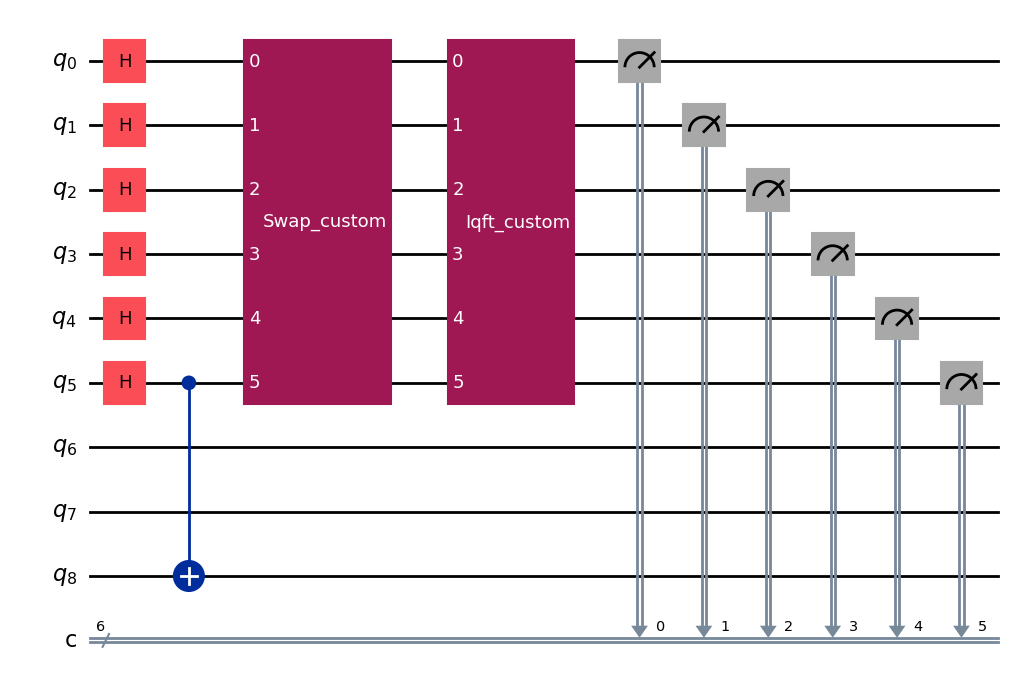

In [7]:
qc = QuantumCircuit(t+s,t)  #Tenemos t+s qbits,t de estimacion y s de apoyo

iqft_1=IQFT(t) #Unicamente aplicaremos la compuerta a los qbits de estimacion

#Aplicamos compuertas de hadamard en los qbits de precision
for j in range(t):  
   qc.h(j)  


#suponemos un periodo de 2

#detectar impares

qc.cx(t-1,t+s-1)


qc.append(SWAP(t),range(t))
qc.append(iqft_1, range(t))   

qc.measure(range(t), range(t))
qc.draw('mpl')

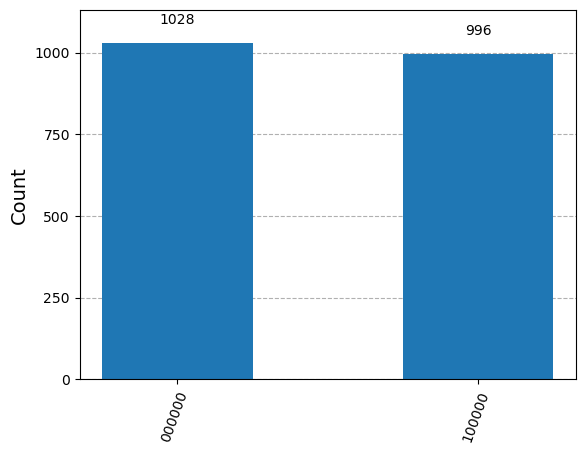

In [8]:
#------Obtencion del histograma ----------------

backend=Aer.get_backend('qasm_simulator')  
#podemos cambiar a 'qasm_simulator' , ya que 'statevector_simulator' no es compatible con mediciones clasicas

compilado=transpile(qc, backend)  
#transpile es una funcion que optimiza el circuito cuantico para que sea compatible con el backend seleccionado. 

job=backend.run(compilado, shots=2024)  
#Ejecutamos el circuito cuantico 
#Shots, especifica cuantas veces se ejecuta el circuito cuantico ( recordemos que la cuantica es probabilistica)

result=job.result() #Obtiene los resultados del lo anterior

# Graficamos el histograma de resultados
plot_histogram(result.get_counts()) 

In [9]:
# Cuentas
counts = result.get_counts()

# Listas para almacenar los resultados
valores_binarios = []
valores_decimales = []

# Itera sobre todos los valores en counts
for valor_binario in counts:
    # Guarda el valor binario y su valor decimal
    valores_binarios.append(valor_binario)
    valores_decimales.append(int(valor_binario, 2))

# Imprime los resultados
print("Todos los valores binarios:", valores_binarios)
print("Todos los valores decimales:", valores_decimales)

Todos los valores binarios: ['100000', '000000']
Todos los valores decimales: [32, 0]


In [10]:
#Algoritmo de Fraccion Continua 

from fractions import Fraction

def continued_fraction(x, max_iterations=100):
    #Devuelve los coeficientes de la fracción continua de x
    cf = []  # Lista para almacenar los coeficientes de la fracción continua
    while max_iterations > 0:
        # Obtener la parte entera
        a = int(x) #redondea al menor entero cercano
        cf.append(a) #añade a a a la lista cf
        
        # Calcular el resto
        x = x - a
        
        # Si el resto es cero, hemos terminado
        if x == 0:
            break
        
        # Tomamos el recíproco del resto para continuar la fracción continua
        x = 1 / x
        max_iterations -= 1
    
    return cf

def approximate_fraction(cf):
    """Toma los coeficientes de una fracción continua y devuelve la aproximación como una fracción."""
    n = len(cf)
    
    # Manejo especial si la fracción continua es muy pequeña
    if n == 0:
        return Fraction(0)
    
    # Inicializamos con la última fracción (el último término)
    frac = Fraction(cf[-1])
    
    # Empezamos a recorrer los términos de la fracción continua en orden inverso
    for a in reversed(cf[:-1]):
        frac = a + 1 / frac
    
    return frac




In [11]:
# Listas para almacenar los resultados intermedios
x = []
cf = []
approx_frac = []
r = []

# Itera sobre todos los valores decimales obtenidos previamente
for i in range(len(valores_decimales)): 
    if valores_decimales[i]==0:
        print(f"Valor decimal x[{i}] es 0, pasando al siguiente valor.")
        continue  # Salta el resto del procesamiento para este valor

    print(f"Paso para el valor {valores_decimales[i]}")
    x_val = valores_decimales[i]/ 2**t  # Aproximación decimal
    x.append(x_val)
    
    # Calcula la fracción continua completa
    cf_val = continued_fraction(x_val)
    print(f"Fracción continua sin ceros iniciales: {cf_val}")
    cf.append(cf_val)

    approx_val = approximate_fraction(cf_val)
    approx_frac.append(approx_val)
        
     # Obtén el denominador de la fracción aproximada
    r_val = approx_val.denominator
    r.append(r_val)

    # Imprime los resultados paso a paso
    print(f"Fracción continua: {cf_val}")
    print(f"Fracción aproximada usando hasta el término  {approx_val}")
    print(f"La fase aproximada (denominador) en este paso es: {r_val}")
    print("\n")

Paso para el valor 32
Fracción continua sin ceros iniciales: [0, 2]
Fracción continua: [0, 2]
Fracción aproximada usando hasta el término  1/2
La fase aproximada (denominador) en este paso es: 2


Valor decimal x[1] es 0, pasando al siguiente valor.
